In [1]:
#! /usr/bin/python3
""" 01 - Generative Adversarial Networks (GAN) for MNIST.

Using generative adversarial networks (GAN) to generate digit images from a
noise distribution.

References:
    - [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
    - [Generative Adversarial Networks (LIVE) - Siraj Raval](https://www.youtube.com/watch?v=0VPQHbMvGzg)
    - [Deep Convolutional Generative Adversarial Network Example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dcgan.ipynb)
    - [m516825 - Conditional-GAN](https://github.com/m516825/Conditional-GAN)
    
Author: Paweł Kubiak
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt #visualize results
from tqdm import tqdm
%matplotlib inline

BATCH_SIZE = 64
LABEL_SIZE = 10
NOISE_SIZE = 100

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# Build discriminator network
def discriminator(input, labels, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        # Convolution Layer #1: (x, 32, 32, 1)
        conv1 = tf.layers.conv2d(input, 32, 5, padding= 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training = is_training)
        conv1 = tf.nn.leaky_relu(conv1)
        conv1 = tf.layers.average_pooling2d(conv1, 2, 2, padding = 'SAME')
        
        # Add labels: (x, 16, 16, 32)
        labels = tf.expand_dims(tf.expand_dims(labels, 1), 2)
        labels = tf.tile(labels, [1, 16, 16, 1])
        labels = tf.concat([conv1, labels], 3)
        
        # Convolution Layer #2: (x, 16, 16, 42)
        conv2 = tf.layers.conv2d(labels, 64, 5, padding= 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training = is_training)
        conv2 = tf.nn.leaky_relu(conv2)
        conv2 = tf.layers.average_pooling2d(conv2, 2, 2, padding = 'SAME')

        # Convolution Layer #3: (x, 8, 8, 84)
        conv3 = tf.layers.conv2d(conv2, 128, 5, padding= 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training = is_training)
        conv3 = tf.nn.leaky_relu(conv3)
        conv3 = tf.layers.average_pooling2d(conv3, 2, 2, padding = 'SAME')

        # Fully Connected Layer #2 -> return 2 label: FAKE, REAL
        full1 = tf.reshape(conv3, [conv3.shape[0], -1])
        full1 = tf.layers.dense(full1, 2)
        
        return full1

In [4]:
# Build generator network
def generator(noise, labels):
    with tf.variable_scope('generator', reuse = tf.AUTO_REUSE):
#         
        input = tf.concat([noise, labels], axis = 1)
        full1 = tf.layers.dense(input, units = 4 * 4 * 128)
        full1 = tf.layers.batch_normalization(full1, training = is_training)
        full1 = tf.nn.leaky_relu(full1)
#         full1 = tf.nn.tanh(full1)
        
        full1 = tf.reshape(full1, [-1, 4, 4, 128])

        # Deconvolution #1: (x, 4, 4, 128) -> (x, 8, 8, y)
        deconv1 = tf.layers.conv2d_transpose(full1, 64, 5, strides=2, padding = 'SAME')
        deconv1 = tf.layers.batch_normalization(deconv1, training = is_training)
        deconv1 = tf.nn.leaky_relu(deconv1)
        
        dropout1 = tf.layers.dropout(deconv1, 0.1)
        
        # Deconvolution #2: (x, 8, 8, y) -> (x, 16, 16, y2)
        deconv2 = tf.layers.conv2d_transpose(dropout1, 32, 5, strides = 2, padding = 'SAME')
        deconv2 = tf.layers.batch_normalization(deconv2, training = is_training)
        deconv2 = tf.nn.leaky_relu(deconv2)
        
        dropout2 = tf.layers.dropout(deconv2, 0.05)
        
        # Final Deconvolution        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 1, 5, strides = 2, padding = 'SAME')
        
        return tf.tanh(deconv3)

# noise = tf.truncated_normal(shape = [BATCH_SIZE, NOISE_SIZE])

# G = generator(noise, tf.placeholder('float', shape = [32, 10]))
# print(G)

In [5]:
tf.reset_default_graph()
is_training = tf.placeholder('bool', name = 'is_training')

labels = tf.placeholder('float', shape = [BATCH_SIZE, LABEL_SIZE], name = 'labels')
images = tf.placeholder('float', shape = [BATCH_SIZE, 32, 32, 1], name = 'images')
noise = tf.placeholder('float', shape = [BATCH_SIZE, NOISE_SIZE], name = 'noise')

# Discriminators
disc_real = discriminator(images, labels)
disc_fake = discriminator(generator(noise, labels), labels, True)

# Loss functions

gen_loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = disc_fake,
        labels = tf.ones(dtype=tf.int32, shape = [BATCH_SIZE])
    )
)

disc_loss_real = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = disc_real, 
        labels = tf.ones(dtype=tf.int32, shape = [BATCH_SIZE])
    )
)

disc_loss_fake = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = disc_fake,
        labels = tf.zeros(dtype=tf.int32, shape = [BATCH_SIZE])
    )
)

disc_loss = disc_loss_real + disc_loss_fake

In [6]:
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

# vvvv Magic vvvv - Very important !
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
    d_trainer = tf.train.AdamOptimizer(0.0001).minimize(disc_loss, var_list=disc_vars)

    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(disc_loss_real, var_list=disc_vars)
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(disc_loss_fake, var_list=disc_vars)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(gen_loss, var_list=gen_vars)

init = tf.global_variables_initializer()

epoch: 1 (200) dLoss: 0.404731 gLoss: 2.68987 d_count: 537 g_count: 1223


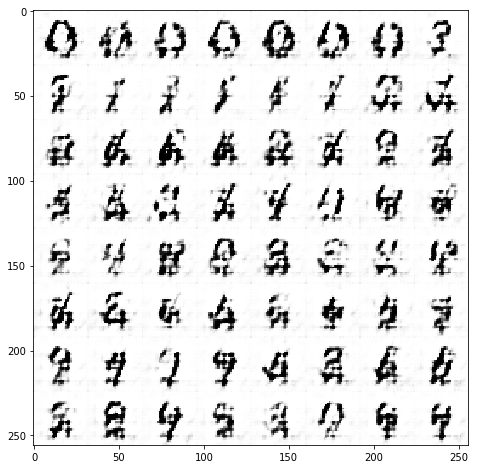

epoch: 2 (400) dLoss: 0.442876 gLoss: 1.86557 d_count: 714 g_count: 1145


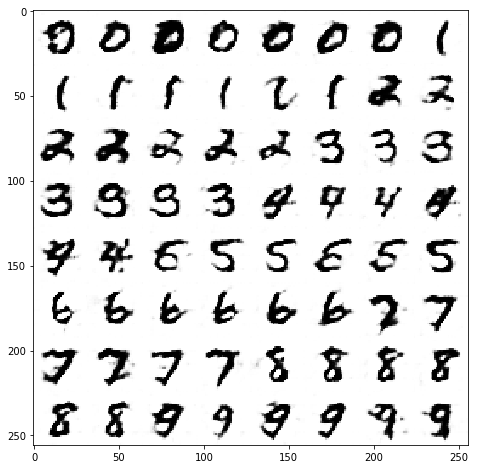

epoch: 3 (600) dLoss: 0.514631 gLoss: 1.92805 d_count: 660 g_count: 1145


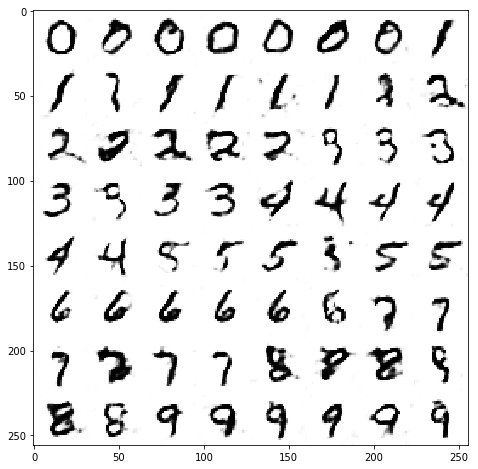

epoch: 4 (800) dLoss: 0.44197 gLoss: 2.39479 d_count: 792 g_count: 1000


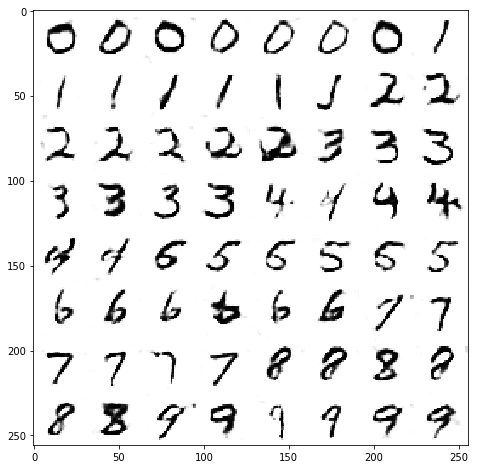

epoch: 5 (1000) dLoss: 0.439548 gLoss: 1.80994 d_count: 810 g_count: 960


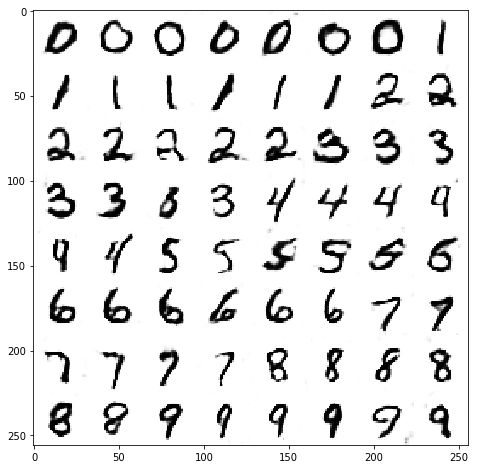

epoch: 6 (1200) dLoss: 0.542404 gLoss: 1.86286 d_count: 870 g_count: 925


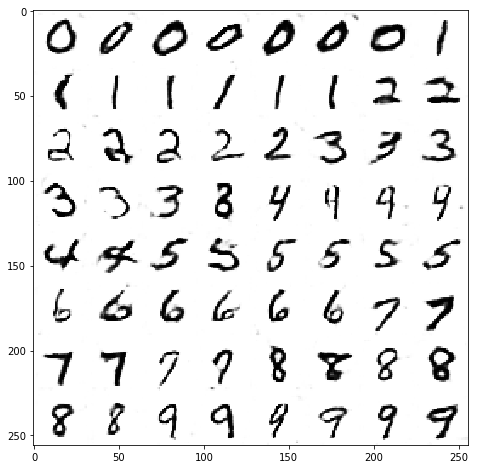

epoch: 7 (1400) dLoss: 0.527668 gLoss: 1.67572 d_count: 871 g_count: 890


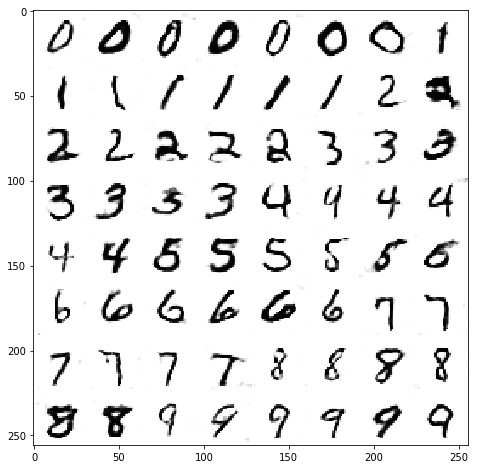

epoch: 8 (1600) dLoss: 0.425475 gLoss: 2.40681 d_count: 874 g_count: 941


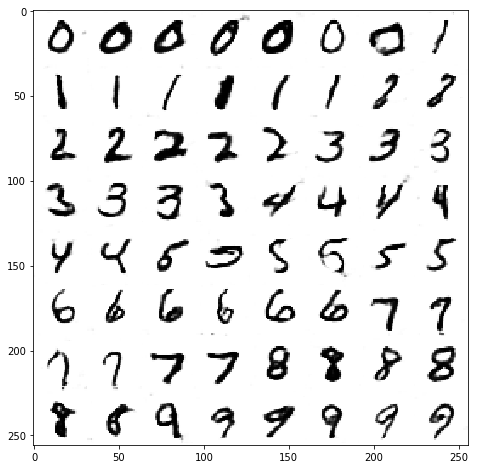

epoch: 9 (1800) dLoss: 0.706081 gLoss: 1.44937 d_count: 863 g_count: 889


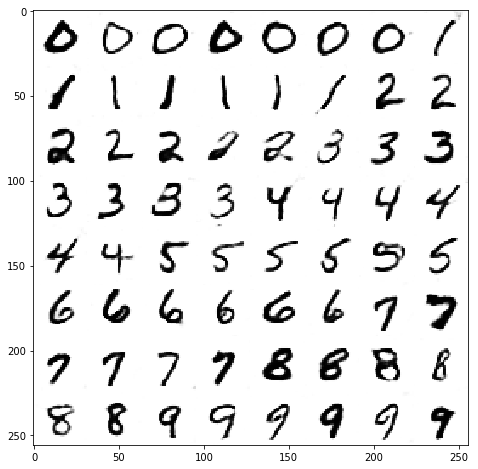

epoch: 10 (2000) dLoss: 0.536655 gLoss: 1.1686 d_count: 845 g_count: 936


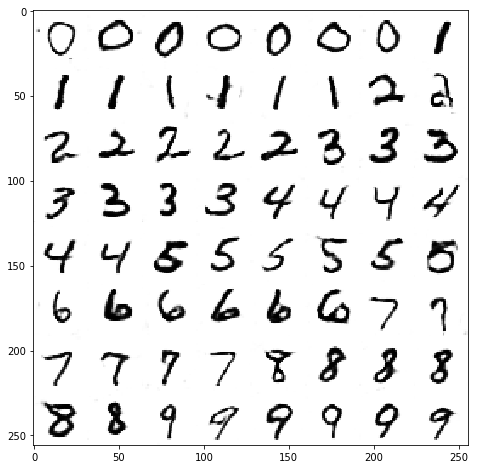

epoch: 11 (2200) dLoss: 0.677359 gLoss: 2.13791 d_count: 826 g_count: 933


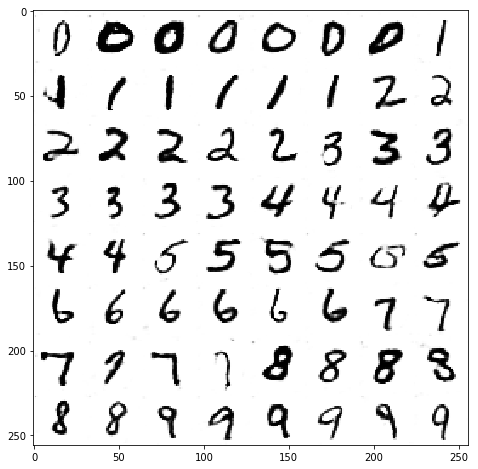

epoch: 12 (2400) dLoss: 0.524805 gLoss: 2.52544 d_count: 856 g_count: 933


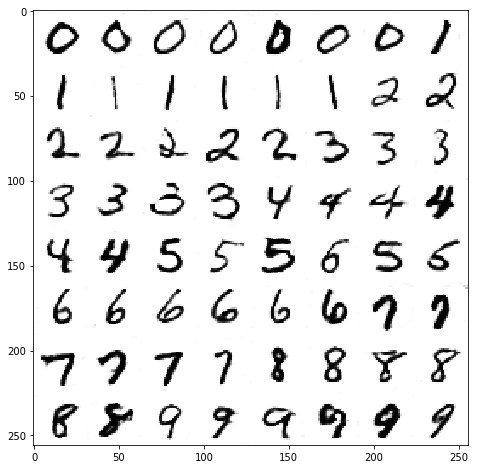

epoch: 13 (2600) dLoss: 0.602038 gLoss: 0.924858 d_count: 833 g_count: 952


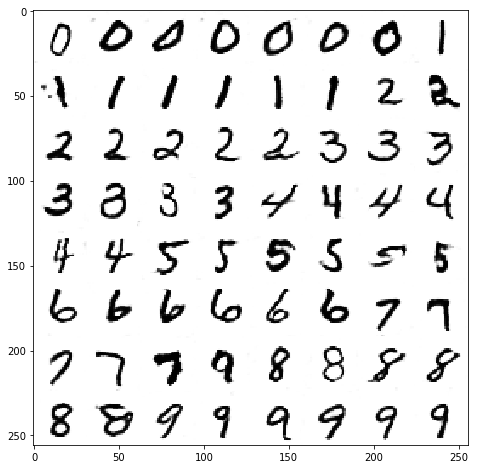

epoch: 14 (2800) dLoss: 0.344995 gLoss: 1.7982 d_count: 820 g_count: 968


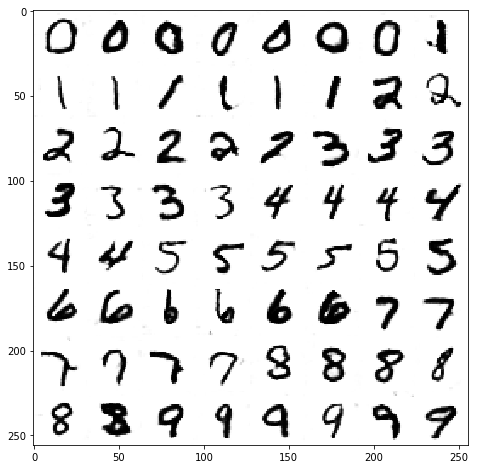

epoch: 15 (3000) dLoss: 0.350005 gLoss: 2.47767 d_count: 791 g_count: 1059


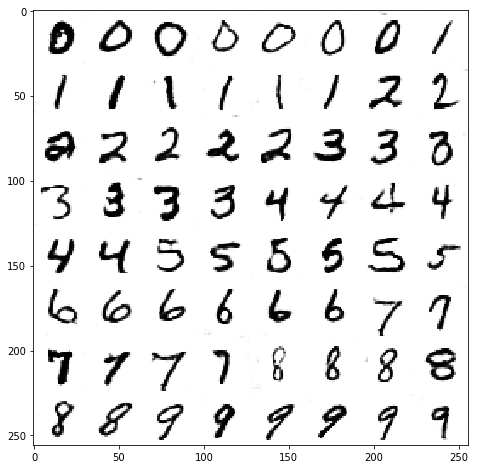

epoch: 16 (3200) dLoss: 0.444157 gLoss: 1.97248 d_count: 786 g_count: 1075


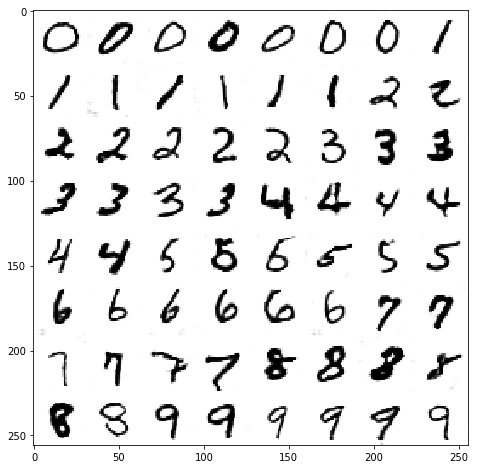

epoch: 17 (3400) dLoss: 0.62232 gLoss: 1.76552 d_count: 788 g_count: 1035


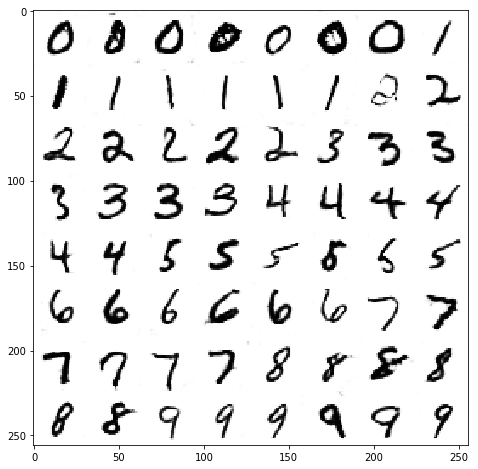

epoch: 18 (3600) dLoss: 0.385789 gLoss: 2.17583 d_count: 746 g_count: 1103


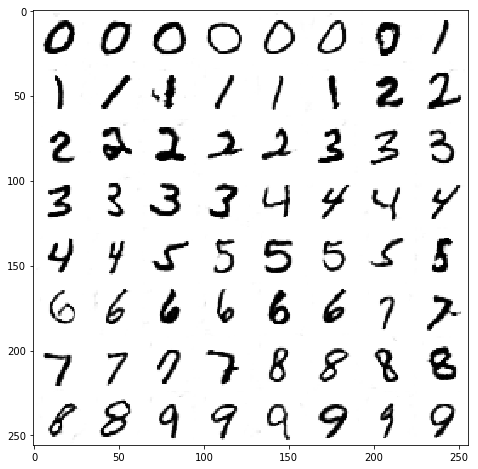

epoch: 19 (3800) dLoss: 0.438629 gLoss: 0.992228 d_count: 750 g_count: 1055


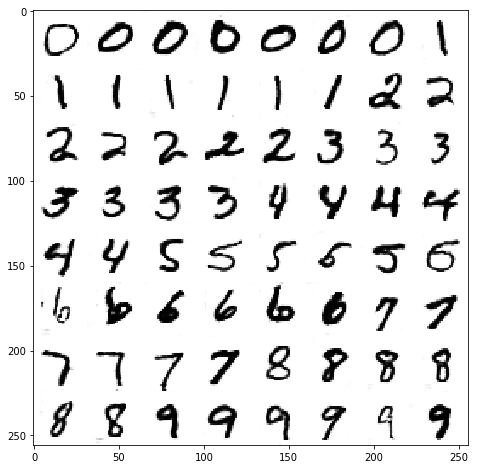

epoch: 20 (4000) dLoss: 0.455512 gLoss: 3.07189 d_count: 687 g_count: 1124


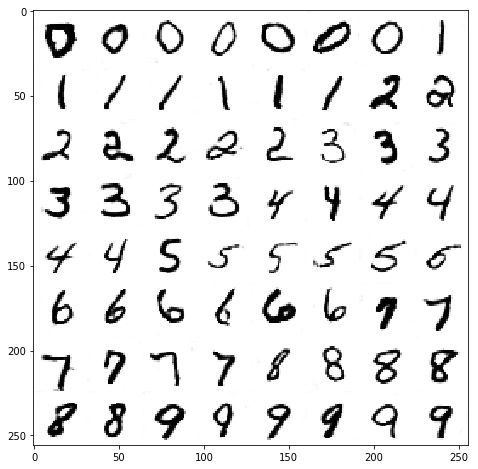

In [11]:
def get_data():
    batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    # batch_x = tf.image.resize_images(batch_x, [32,32]).eval(session=sess)
    batch_x = np.pad(batch_x, [(0,0), (2,2), (2,2), (0,0)], 'edge')
#     batch_x += np.random.normal(0.0, 0.02, size = [BATCH_SIZE, 32, 32, 1])
    batch_x = 2.0 * batch_x - 1.0
    return batch_x, batch_y
def get_labels():
    res = np.zeros(shape = [BATCH_SIZE, LABEL_SIZE])
    res[range(BATCH_SIZE),np.random.randint(0, LABEL_SIZE, size = BATCH_SIZE)] += 1
    return res

def get_noise():
    return np.random.uniform(-1., 1., size=[BATCH_SIZE, NOISE_SIZE]) 



arr = [0]*BATCH_SIZE
for i in range(BATCH_SIZE):
    arr[i] = i%10
arr.sort()
lab2 = np.zeros(shape = [BATCH_SIZE, LABEL_SIZE])
lab2[range(BATCH_SIZE),arr] = 1


sess = tf.Session()

sess.run(init)

gLoss = 0
dLossFake, dLossReal, dLoss = 1, 1, 1
d_fake_count, d_real_count, g_count = 0, 0, 0

STEP_PER_EPOCH = 200
        
for epoch in range(1, 21):
    d_count = g_count = 0
    for step in tqdm(range(0, STEP_PER_EPOCH)): 
        for i in range(5):
            batch_x, batch_y = get_data()
            _, dLoss = sess.run([d_trainer, disc_loss], {
                labels: batch_y,
                is_training: True,
                noise: get_noise(),
                images: batch_x
            })
            d_count += 1
            if dLoss < 0.45: break
        ile = 3 + (5 if 4*dLoss < gLoss else 0)
        for i in range(ile):
            batch_x, batch_y = get_data()
            _, gLoss = sess.run([g_trainer, gen_loss], {
                noise: get_noise(),
                labels: get_labels(),
                is_training: True,
            })
            g_count += 1
            if gLoss < 0.7: break

    print('epoch:', epoch,'('+str(epoch*STEP_PER_EPOCH)+')', 'dLoss:', dLoss, 'gLoss:', gLoss, 'd_count:', d_count, 'g_count:', g_count)
    
    imgs, = sess.run([generator(noise, labels)], {
        noise: get_noise(),
        labels: lab2,
        is_training: False,
    })
    imgs = (-imgs + 1.0) / 2.0

#     hist, bins = np.histogram(imgs, bins=50)
#     width = 0.7 * (bins[1] - bins[0])
#     center = (bins[:-1] + bins[1:]) / 2
#     plt.bar(center, hist, align='center', width=width)
#     plt.show()


    n = 8
    canvas = np.empty((32 * n, 32 * n))
    for i in range(n):
        for j in range(n):
            # Draw the generated digits
            canvas[i * 32:(i + 1) * 32, j * 32:(j + 1) * 32] = imgs[8*i+j].reshape([32, 32])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()